In [8]:
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import os
import torch
from tqdm import tqdm
import heapq  # Für effizientes Sortieren der Top 5 Bilder

# Erstellen einer JSON Datei, welche für alle KLassen die Pfade zu den 5 Bildern mit der höchsten Anzahl an Pixeln für diese eine Klasse enthält

In [9]:
val_path = "Mapillary_Vistas/training/images"
val_ann_path = "Mapillary_Vistas/training/v2.0/labels"

In [10]:
# Zelle 1: Definition der Mapillary-Klassen als Dictionary
mapillary_classes = {
    0: {"name": "Bird", "color": (165, 42, 42)},
    1: {"name": "Ground Animal", "color": (0, 192, 0)},
    2: {"name": "Ambiguous Barrier", "color": (250, 170, 31)},
    3: {"name": "Concrete Block", "color": (250, 170, 32)},
    4: {"name": "Curb", "color": (196, 196, 196)},
    5: {"name": "Fence", "color": (190, 153, 153)},
    6: {"name": "Guard Rail", "color": (180, 165, 180)},
    7: {"name": "Barrier", "color": (90, 120, 150)},
    8: {"name": "Road Median", "color": (250, 170, 33)},
    9: {"name": "Road Side", "color": (250, 170, 34)},
    10: {"name": "Lane Separator", "color": (128, 128, 128)},
    11: {"name": "Temporary Barrier", "color": (250, 170, 35)},
    12: {"name": "Wall", "color": (102, 102, 156)},
    13: {"name": "Bike Lane", "color": (128, 64, 255)},
    14: {"name": "Crosswalk - Plain", "color": (140, 140, 200)},
    15: {"name": "Curb Cut", "color": (170, 170, 170)},
    16: {"name": "Driveway", "color": (250, 170, 36)},
    17: {"name": "Parking", "color": (250, 170, 160)},
    18: {"name": "Parking Aisle", "color": (250, 170, 37)},
    19: {"name": "Pedestrian Area", "color": (96, 96, 96)},
    20: {"name": "Rail Track", "color": (230, 150, 140)},
    21: {"name": "Road", "color": (128, 64, 128)},
    22: {"name": "Road Shoulder", "color": (110, 110, 110)},
    23: {"name": "Service Lane", "color": (110, 110, 110)},
    24: {"name": "Sidewalk", "color": (244, 35, 232)},
    25: {"name": "Traffic Island", "color": (128, 196, 128)},
    26: {"name": "Bridge", "color": (150, 100, 100)},
    27: {"name": "Building", "color": (70, 70, 70)},
    28: {"name": "Garage", "color": (150, 150, 150)},
    29: {"name": "Tunnel", "color": (150, 120, 90)},
    30: {"name": "Person", "color": (220, 20, 60)},
    31: {"name": "Person Group", "color": (220, 20, 60)},
    32: {"name": "Bicyclist", "color": (255, 0, 0)},
    33: {"name": "Motorcyclist", "color": (255, 0, 100)},
    34: {"name": "Other Rider", "color": (255, 0, 200)},
    35: {"name": "Lane Marking - Dashed Line", "color": (255, 255, 255)},
    36: {"name": "Lane Marking - Straight Line", "color": (255, 255, 255)},
    37: {"name": "Lane Marking - Zigzag Line", "color": (250, 170, 29)},
    38: {"name": "Lane Marking - Ambiguous", "color": (250, 170, 28)},
    39: {"name": "Lane Marking - Arrow (Left)", "color": (250, 170, 26)},
    40: {"name": "Lane Marking - Arrow (Other)", "color": (250, 170, 25)},
    41: {"name": "Lane Marking - Arrow (Right)", "color": (250, 170, 24)},
    42: {"name": "Lane Marking - Arrow (Split Left or Straight)", "color": (250, 170, 22)},
    43: {"name": "Lane Marking - Arrow (Split Right or Straight)", "color": (250, 170, 21)},
    44: {"name": "Lane Marking - Arrow (Straight)", "color": (250, 170, 20)},
    45: {"name": "Lane Marking - Crosswalk", "color": (255, 255, 255)},
    46: {"name": "Lane Marking - Give Way (Row)", "color": (250, 170, 19)},
    47: {"name": "Lane Marking - Give Way (Single)", "color": (250, 170, 18)},
    48: {"name": "Lane Marking - Hatched (Chevron)", "color": (250, 170, 12)},
    49: {"name": "Lane Marking - Hatched (Diagonal)", "color": (250, 170, 11)},
    50: {"name": "Lane Marking - Other", "color": (255, 255, 255)},
    51: {"name": "Lane Marking - Stop Line", "color": (255, 255, 255)},
    52: {"name": "Lane Marking - Symbol (Bicycle)", "color": (250, 170, 16)},
    53: {"name": "Lane Marking - Symbol (Other)", "color": (250, 170, 15)},
    54: {"name": "Lane Marking - Text", "color": (250, 170, 15)},
    55: {"name": "Lane Marking (only) - Dashed Line", "color": (255, 255, 255)},
    56: {"name": "Lane Marking (only) - Crosswalk", "color": (255, 255, 255)},
    57: {"name": "Lane Marking (only) - Other", "color": (255, 255, 255)},
    58: {"name": "Lane Marking (only) - Test", "color": (255, 255, 255)},
    59: {"name": "Mountain", "color": (64, 170, 64)},
    60: {"name": "Sand", "color": (230, 160, 50)},
    61: {"name": "Sky", "color": (70, 130, 180)},
    62: {"name": "Snow", "color": (190, 255, 255)},
    63: {"name": "Terrain", "color": (152, 251, 152)},
    64: {"name": "Vegetation", "color": (107, 142, 35)},
    65: {"name": "Water", "color": (0, 170, 30)},
    66: {"name": "Banner", "color": (255, 255, 128)},
    67: {"name": "Bench", "color": (250, 0, 30)},
    68: {"name": "Bike Rack", "color": (100, 140, 180)},
    69: {"name": "Catch Basin", "color": (220, 128, 128)},
    70: {"name": "CCTV Camera", "color": (222, 40, 40)},
    71: {"name": "Fire Hydrant", "color": (100, 170, 30)},
    72: {"name": "Junction Box", "color": (40, 40, 40)},
    73: {"name": "Mailbox", "color": (33, 33, 33)},
    74: {"name": "Manhole", "color": (100, 128, 160)},
    75: {"name": "Parking Meter", "color": (20, 20, 255)},
    76: {"name": "Phone Booth", "color": (142, 0, 0)},
    77: {"name": "Pothole", "color": (70, 100, 150)},
    78: {"name": "Signage - Advertisement", "color": (250, 171, 30)},
    79: {"name": "Signage - Ambiguous", "color": (250, 172, 30)},
    80: {"name": "Signage - Back", "color": (250, 173, 30)},
    81: {"name": "Signage - Information", "color": (250, 174, 30)},
    82: {"name": "Signage - Other", "color": (250, 175, 30)},
    83: {"name": "Signage - Store", "color": (250, 176, 30)},
    84: {"name": "Street Light", "color": (210, 170, 100)},
    85: {"name": "Pole", "color": (153, 153, 153)},
    86: {"name": "Pole Group", "color": (153, 153, 153)},
    87: {"name": "Traffic Sign Frame", "color": (128, 128, 128)},
    88: {"name": "Utility Pole", "color": (0, 0, 80)},
    89: {"name": "Traffic Cone", "color": (210, 60, 60)},
    90: {"name": "Traffic Light - General (Single)", "color": (250, 170, 30)},
    91: {"name": "Traffic Light - Pedestrians", "color": (250, 170, 30)},
    92: {"name": "Traffic Light - General (Upright)", "color": (250, 170, 30)},
    93: {"name": "Traffic Light - General (Horizontal)", "color": (250, 170, 30)},
    94: {"name": "Traffic Light - Cyclists", "color": (250, 170, 30)},
    95: {"name": "Traffic Light - Other", "color": (250, 170, 30)},
    96: {"name": "Traffic Sign - Ambiguous", "color": (192, 192, 192)},
    97: {"name": "Traffic Sign (Back)", "color": (192, 192, 192)},
    98: {"name": "Traffic Sign - Direction (Back)", "color": (192, 192, 192)},
    99: {"name": "Traffic Sign - Direction (Front)", "color": (220, 220, 0)},
    100: {"name": "Traffic Sign (Front)", "color": (220, 220, 0)},
    101: {"name": "Traffic Sign - Parking", "color": (0, 0, 196)},
    102: {"name": "Traffic Sign - Temporary (Back)", "color": (192, 192, 192)},
    103: {"name": "Traffic Sign - Temporary (Front)", "color": (220, 220, 0)},
    104: {"name": "Trash Can", "color": (140, 140, 20)},
    105: {"name": "Bicycle", "color": (119, 11, 32)},
    106: {"name": "Boat", "color": (150, 0, 255)},
    107: {"name": "Bus", "color": (0, 60, 100)},
    108: {"name": "Car", "color": (0, 0, 142)},
    109: {"name": "Caravan", "color": (0, 0, 90)},
    110: {"name": "Motorcycle", "color": (0, 0, 230)},
    111: {"name": "On Rails", "color": (0, 80, 100)},
    112: {"name": "Other Vehicle", "color": (128, 64, 64)},
    113: {"name": "Trailer", "color": (0, 0, 110)},
    114: {"name": "Truck", "color": (0, 0, 70)},
    115: {"name": "Vehicle Group", "color": (0, 0, 142)},
    116: {"name": "Wheeled Slow", "color": (0, 0, 192)},
    117: {"name": "Water Valve", "color": (170, 170, 170)},
    118: {"name": "Car Mount", "color": (32, 32, 32)},
    119: {"name": "Dynamic", "color": (111, 74, 0)},
    120: {"name": "Ego Vehicle", "color": (120, 10, 10)},
    121: {"name": "Ground", "color": (81, 0, 81)},
    122: {"name": "Static", "color": (111, 111, 0)},
    123: {"name": "Unlabeled", "color": (0, 0, 0)}
}


Run nur auf True setzen, wenn eine neue Datei erstellt werden soll. UNBEDINGT den Namen der Output-JSON Datei ändern, da sonst bestehende Daten überschrieben werden

In [11]:
run = False

In [12]:

if run:
    # Initialisiere das Dictionary für die besten 5 Bilder pro Klasse (als Liste)
    best_images = {
        class_id: {
            "class_name": mapillary_classes[class_id]["name"],
            "top_images": []  # Liste mit bis zu 5 Einträgen
        }
        for class_id in mapillary_classes.keys()
    }

    # Prüfe, welche Bilddateien existieren (unabhängig von der Endung)
    available_images = {os.path.splitext(f)[0]: f for f in os.listdir(val_path)}
    print(f"📂 Gefundene Bilder: {len(available_images)} Dateien")

    # Stelle sicher, dass CUDA verfügbar ist
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"⚡ Verwende Gerät: {device}")

    # Lade jede Annotation, verarbeite sie auf der GPU und aktualisiere das Dictionary
    for file_name in tqdm(os.listdir(val_ann_path), desc="Analysiere Annotationen mit GPU"):
        annotation_path = os.path.join(val_ann_path, file_name)
        file_base, _ = os.path.splitext(file_name)  # Dateiname ohne Endung
        
        try:
            # Lade das Labelbild im Modus "P" (indizierte Farbpalette)
            annotation = Image.open(annotation_path)
            if annotation.mode != "P":
                print(f"⚠️ Unerwarteter Modus {annotation.mode} für {file_name}, wird übersprungen.")
                continue

            # Konvertiere die Bilddaten in ein numpy-Array mit direkten Indexwerten
            ann_np = np.array(annotation)  # Direktes Arbeiten mit den Indexwerten

        except Exception as e:
            print(f"❌ Fehler beim Öffnen der Annotation {annotation_path}: {e}")
            continue

        # Konvertiere das Bild zu einem Torch-Tensor auf der GPU
        ann_tensor = torch.tensor(ann_np, device=device)

        # Bestimme alle eindeutigen Klassen-IDs und ihre Pixelanzahl
        unique_classes, pixel_counts = torch.unique(ann_tensor, return_counts=True)

        # Konvertiere die Ergebnisse zurück auf die CPU
        unique_classes = unique_classes.cpu().numpy()
        pixel_counts = pixel_counts.cpu().numpy()

        # Prüfe, ob es ein passendes Bild gibt (unabhängig von der Dateiendung)
        if file_base in available_images:
            image_path = os.path.join(val_path, available_images[file_base])
        else:
            print(f"⚠️ Fehlendes Bild für {file_name}, wird übersprungen.")
            continue

        # Überprüfe für jede Klasse, ob dieses Bild unter die Top 5 kommt
        for class_id, count in zip(unique_classes, pixel_counts):
            class_id = int(class_id)  # Sicherstellen, dass der Schlüssel integer ist

            if class_id in best_images:
                # Erstelle den neuen Eintrag
                new_entry = {
                    "image_path": image_path,
                    "annotation_path": annotation_path,
                    "pixel_count": int(count)
                }

                # Füge das Bild zur Liste hinzu und behalte nur die 5 besten Einträge
                best_images[class_id]["top_images"].append(new_entry)
                best_images[class_id]["top_images"] = sorted(
                    best_images[class_id]["top_images"],
                    key=lambda x: x["pixel_count"],
                    reverse=True
                )[:5]  # Behalte nur die Top 5 Bilder

    # Speichere die Ergebnisse als JSON-Datei
    json_output_path = "best_5_class_images_train_gpu.json"
    with open(json_output_path, "w", encoding="utf-8") as f:
        json.dump(best_images, f, indent=4)

    print(f"✅ Ergebnisse gespeichert unter: {json_output_path}")


In [13]:
# Lade das JSON mit den besten Bildern
json_path = "best_5_class_images_train_gpu.json"
with open(json_path, "r", encoding="utf-8") as f:
    best_class_images = json.load(f)

def visualize_top5_images(class_id: int):
    """
    Zeigt die Top 5 Bilder für eine gegebene Klasse nebeneinander an,
    wobei die Klasse farblich hervorgehoben wird.

    Args:
        class_id (int): Die gewünschte Klasse (ID aus Mapillary)
    """
    # Sicherstellen, dass die Klasse existiert und Bilder hat
    str_class_id = str(class_id)
    if str_class_id not in best_class_images or not best_class_images[str_class_id]["top_images"]:
        print(f"⚠️ Keine Bilddaten für Klasse {class_id} vorhanden.")
        return
    
    top_images = best_class_images[str_class_id]["top_images"]
    num_images = len(top_images)  # Anzahl der verfügbaren Bilder

    # Visualisierung
    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 4, 8))

    for i, img_data in enumerate(top_images):
        # Lade das Originalbild
        image_path = img_data["image_path"]
        annotation_path = img_data["annotation_path"]

        original_img = Image.open(image_path).convert("RGB")
        annotation = Image.open(annotation_path)  # Bleibt im Modus "P"

        # Konvertiere in numpy arrays
        original_np = np.array(original_img)
        annotation_np = np.array(annotation)

        # Erstelle eine Maske für die ausgewählte Klasse
        class_mask = (annotation_np == class_id).astype(np.uint8) * 255  # Binäre Maske

        # Erstelle eine farbige Overlay-Maske
        overlay = np.zeros_like(original_np, dtype=np.uint8)
        overlay[class_mask > 0] = (255, 0, 0)  # Rote Markierung für die Klasse

        # Überlagere das Originalbild mit der farbigen Maske
        highlighted_img = cv2.addWeighted(original_np, 1.0, overlay, 0.5, 0)

        # Zeige das Originalbild
        axes[0, i].imshow(original_np)
        axes[0, i].set_title(f"Original #{i+1}")
        axes[0, i].axis("off")

        # Zeige das Bild mit der hervorgehobenen Klasse
        axes[1, i].imshow(highlighted_img)
        axes[1, i].set_title(f"Hervorgehoben: {best_class_images[str_class_id]['class_name']}")
        axes[1, i].axis("off")

    plt.suptitle(f"Top {num_images} Bilder für Klasse {best_class_images[str_class_id]['class_name']}", fontsize=14)
    plt.show()



Zeigt für eine Klasse die 5 Bilder an. Obere Reihe das originale Bild, untere Reihe die Klassenpixel farblich hervorgehoben

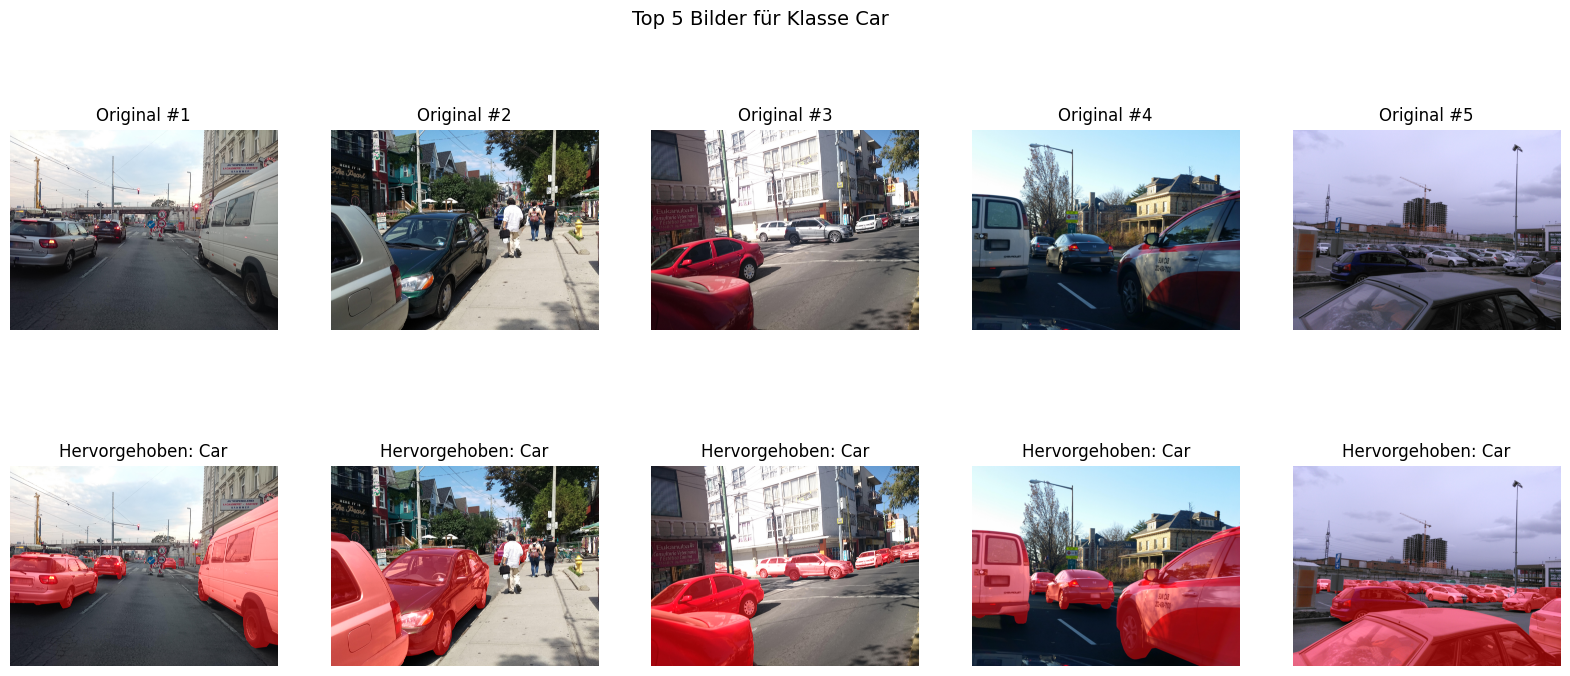

In [16]:
class_id = 108

visualize_top5_images(class_id)
